competition name: Cassava Disease Classification \\
team name: Tihraga \\
link1: https://www.kaggle.com/c/ammi-2021-convnets/leaderboard \\



In [ ]:
import shutil
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F
from torchvision import datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pylab as plt
%matplotlib inline
from PIL import Image
import cv2
import time
import os
import copy
import random
import math
import pprint
plt.ion()  
!pip install pretrainedmodels >/dev/null 2>&1
import pretrainedmodels
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

# Colab's file access feature:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
json_file = '/content/drive/MyDrive/cassave/data/kaggle.json'

Mounted at /content/drive


# Then move kaggle.json into the folder where the API expects to find it:

In [ ]:
!mkdir -p ~/.kaggle/ && cp '/content/drive/MyDrive/cassave/data/kaggle.json' ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

#download data:

In [ ]:
!kaggle competitions download -c cassava-disease

 99% 1.03G/1.04G [00:07<00:00, 145MB/s]
100% 1.04G/1.04G [00:07<00:00, 155MB/s]
100% 777M/777M [00:08<00:00, 32.3MB/s]

  0% 0.00/645k [00:00<?, ?B/s]
100% 645k/645k [00:00<00:00, 89.2MB/s]
 99% 509M/515M [00:10<00:00, 62.6MB/s]
100% 515M/515M [00:10<00:00, 51.1MB/s]
  0% 0.00/83.8k [00:00<?, ?B/s]
100% 83.8k/83.8k [00:00<00:00, 79.9MB/s]


#unzip all data :

In [ ]:
!unzip -qq train.zip
!unzip -qq extraimages.zip
!unzip -qq test.zip

# Exploring Training data

In [ ]:
train_path = './train'
for classes in os.listdir(train_path):
    print('{} : {}'.format(classes, 
                         len(os.listdir(os.path.join(train_path, classes)))
                        ))

healthy : 316
cgm : 773
cmd : 2658
cbb : 466
cbsd : 1443


In [ ]:
def get_labels(file_path): 
    """
    function to get labels 
    --
    INPUTS:
    file_path: (str) the path of the images
    --
    OUTPUTS: label from the path example (healthy,cgm,cmd,cbsd,cbb)
    """
    dir_name = os.path.dirname(file_path)
    split_dir_name = dir_name.split("/")
    dir_levels = len(split_dir_name)
    label  = split_dir_name[dir_levels - 1]
    return(label)

**create image dataFrame**

In [ ]:
# create image data frame containing image paths & labels
from glob import glob
imagePaths = glob("./train/*/*.*", recursive=True)
images_df = pd.DataFrame(columns=['images', 'labels'])
images_df["images"] = imagePaths

labels = []
for img in imagePaths:
    labels.append(get_labels(img))   

images_df["labels"] = labels

In [ ]:
images_df

,images,labels
0,./train/healthy/train-healthy-201.jpg,healthy
1,./train/healthy/train-healthy-216.jpg,healthy
2,./train/healthy/train-healthy-240.jpg,healthy
3,./train/healthy/train-healthy-291.jpg,healthy
4,./train/healthy/train-healthy-302.jpg,healthy
...,...,...
5651,./train/cbsd/train-cbsd-38.jpg,cbsd
5652,./train/cbsd/train-cbsd-1090.jpg,cbsd
5653,./train/cbsd/train-cbsd-426.jpg,cbsd
5654,./train/cbsd/train-cbsd-623.jpg,cbsd


In [ ]:
# assign different label to extra images 
from glob import glob
extra_imagePaths = glob("./extraimages/*.*", recursive=True)
extra_df = pd.DataFrame(columns=['images', 'labels'])
extra_df["images"] = extra_imagePaths

labels = []
for img in extra_imagePaths:
    labels.append(-3)   

extra_df["labels"] = labels

In [ ]:
extra_df

,images,labels
0,./extraimages/extra-image-6998.jpg,-3
1,./extraimages/extra-image-13899.jpg,-3
2,./extraimages/extra-image-10444.jpg,-3
3,./extraimages/extra-image-457.jpg,-3
4,./extraimages/extra-image-15112.jpg,-3
...,...,...
12590,./extraimages/extra-image-14440.jpg,-3
12591,./extraimages/extra-image-1876.jpg,-3
12592,./extraimages/extra-image-1081.jpg,-3
12593,./extraimages/extra-image-10710.jpg,-3


**copy the images_df to use it later**

In [ ]:
images_df_final = images_df.copy()

# Label encoding to encode the labels

In [ ]:
labelencoder = LabelEncoder()
images_df["labels"] = labelencoder.fit_transform(images_df["labels"])

In [ ]:
images_df.head()

,images,labels
0,./train/healthy/train-healthy-201.jpg,4
1,./train/healthy/train-healthy-216.jpg,4
2,./train/healthy/train-healthy-240.jpg,4
3,./train/healthy/train-healthy-291.jpg,4
4,./train/healthy/train-healthy-302.jpg,4


In [ ]:
classes = labelencoder.classes_
print(classes)

['cbb' 'cbsd' 'cgm' 'cmd' 'healthy']


**Function to set up the seed**

In [ ]:
def seed(seed, cuda):
    """
    function to fix the seed
    --
    INPUTS:
    seed: (int) the seed that we wanted to fix
    cuda: (bool) if we are using gpu , then also fix the seed related to cuda 
    --
    OUTPUTS: no output
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


**Function to create directories**

In [ ]:
def create_directories(dir_path):
    """
    function to create directory for checkpoints
    --
    INPUTS:
    dir_path: (str) path of the directory
    --
    OUTPUTS: no output
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

**Load checkpoint function**

In [ ]:
def load_checkpoint(model, optimizer, filename=None):
    """
    function to load the saved checkpoints (to continue the experiment)
    --
    INPUTS:
    model: (model object) 
    optimizer: (optimizer object)
    filename : (str)
    --
    OUTPUTS: model , optimizer , start epoch
    """ 
    # Note: Input model & optimizer should be pre-defined. This routine only updates their states. 
    start_epoch = 0 
    if os.path.isfile(filename): 
        print("=> loading checkpoint '{}'".format(filename)) 
        checkpoint = torch.load(filename) 
        start_epoch = checkpoint['epoch'] 
        model.load_state_dict(checkpoint['state_dict']) 
        #optimizer.load_state_dict(checkpoint['optimizer']) 
        print("=> loaded checkpoint '{}' (epoch {})" .format(filename,
                                                            checkpoint['epoch'])) 
    else: print("=> no checkpoint found at '{}'".format(filename)) 
    return model, optimizer, start_epoch

**filter extra images function (Fixmatch)**

In [ ]:
# last update
def filter_extra_imgs(threshold = 0.9):
    """
    function to filter the extra images given a threshold
    --
    INPUTS:
    threshold: (int) 
    --
    OUTPUTS: data frame contains the filtered images 
    """
  extra_paths = []
  peseudo_labels = []

  for img_path in extra_df['images']:
    img = Image.open(img_path)
    img = weak_trans(img)
    model_ft.eval()
    logits = model_ft(img.unsqueeze_(0).to(device=args.device))
    model_ft.train()
    if logits.max(-1).values.item() > threshold:
      extra_paths.append(img_path)
      peseudo_labels.append(torch.argmax(logits).item())

  df = pd.DataFrame(columns=['images', 'labels'])
  df['images'] = extra_paths
  df['labels'] = peseudo_labels

  return df



In [ ]:
extra_paths = []
peseudo_labels = []

for i in range(3):
  extra_paths.append(extra_df['images'][i])
  peseudo_labels.append(-1)

df = pd.DataFrame(columns=['images', 'labels'])
df['images'] = extra_paths
df['labels'] = peseudo_labels


images_df_copy = images_df.copy()

l_df = pd.concat((images_df_copy, df), axis=0).reset_index( drop =True)
l_df

**configuration for training**

In [ ]:
from argparse import Namespace

args = Namespace(
    size = 448,
    # Model Hyperparameters
    learning_rate = 2e-4,
    batch_size = 4,
    num_epochs = 20,
    valid_num_epochs = 10,
    momentum=0.9,

    # Data Parameters
    mean = torch.tensor([0.485, 0.456, 0.406]),
    std = torch.tensor([0.229, 0.224, 0.225]),
    validation_split = .1,
    shuffle_dataset = True,
    num_folds=5,

    seed= 0,

    # Paths
    save_dir = "/content/drive/MyDrive/kaggle/cassave/",
    train_path = "./train",
    test_path = "./test/0",

    # Runtime hyper parameter
    cuda=True,


)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
seed(args.seed, args.cuda)

# create directories
create_directories(args.save_dir)

Using CUDA: False


In [ ]:
%env TORCH_HOME=$args.save_dir

env: TORCH_HOME=/content/drive/MyDrive/kaggle/cassave/


# plot the training data for more clarification

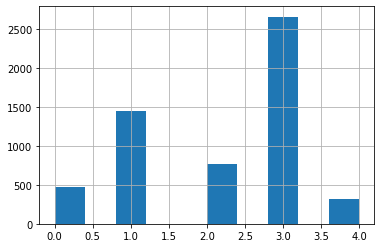

In [ ]:
images_df.labels.hist()
plt.show()

we noticed that class 3 has the highest number of data 

**order the classes based on the number of images**

In [ ]:
images_df.labels.value_counts()

3    2658
1    1443
2     773
0     466
4     316
Name: labels, dtype: int64

# Dataset 

In [ ]:
class CassavaDataset(Dataset):
    def __init__(self, df_data, transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path, label = self.df[index]
        
        image = Image.open(img_path)

        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
class extra_CassavaDataset(Dataset):
    def __init__(self, df_data, train_transform=None, strong_trans=None):
        super().__init__()
        self.df = df_data.values
        
        self.train_transform = train_transform
        self.strong_trans = strong_trans

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path, label = self.df[index]
        
        image = Image.open(img_path)

        if img_path.split('/')[1] == 'train':
          if self.train_transform is not None:
              image = self.train_transform(image)
        else:
          if self.strong_trans is not None:
              image = self.strong_trans(image)

        return image, label

# Set of transformations :

In [ ]:
!pip install randaugment
from randaugment import RandAugment

In [ ]:
train_trans = T.Compose([
        T.RandomResizedCrop(args.size),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.ToTensor(),
        T.Normalize(args.mean, args.std)
    ])

val_trans = T.Compose([
        T.Resize(500),
        T.CenterCrop(args.size),
        T.ToTensor(),
        T.Normalize(args.mean, args.std)
    ])

test_trans = T.Compose([
        T.Resize(500),
        T.CenterCrop(args.size),
        T.ToTensor(),
        T.Normalize(args.mean, args.std)
    ])


weak_trans =  T.Compose([
        T.Resize(448),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomCrop(size=448, 
                      padding=int(448*0.125), 
                      padding_mode='reflect'),
        T.ToTensor(),
        T.Normalize(args.mean, args.std)
    ])


strong_trans =  T.Compose([
        T.Resize(448),
        # T.RandomHorizontalFlip(p=0.5),
        T.RandomCrop(size=448, 
                      padding=int(448*0.125), 
                      padding_mode='reflect'),
      
        # T.RandomErasing(p=1, 
        #                 ratio=(1, 1), 
        #                 scale=(0.01, 0.01), 
        #                 value=127),
        RandAugment(),
        
        T.ToTensor(),
        T.Normalize(args.mean, args.std)    
    ])

#Models:

In [ ]:
def resnet50(pretrained=True):
    """
    function to get pretrained model resnet50 
    --
    INPUTS:
    pretrained: (bool) 
    --
    OUTPUTS: model
    """ 
    model = models.resnet50(pretrained=pretrained)
    return model

def se_resnext50_32x4d(pretrained=True):
    """
    function to get pretrained model resnext50_32x4d
    --
    INPUTS:
    pretrained: (bool) 
    --
    OUTPUTS: model
    """ 
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    return model

def se_resnext101_32x4d(pretrained=True):
    """
    function to get pretrained model resnext101_32x4d
    --
    INPUTS:
    pretrained: (bool) 
    --
    OUTPUTS: model
    """ 
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext101_32x4d(pretrained=pretrained)
    return model

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, model, num_classes=1000):
        super(ResNet50, self).__init__()
        self.backbone = model

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2048, num_classes)
        self.conv_last = nn.Conv2d(512, num_classes, 1)
        

    def forward(self, x):
        
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)


        x = self.backbone.avgpool(x)
        x = self.dropout(x)  

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
class SEResnext101(nn.Module): 
    def __init__(self, model, num_classes=1000): 
        super().__init__() 
        self.backbone = model 
        self.dropout = nn.Dropout(0.5) 
        self.fc = nn.Linear(2048, 5) 
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x): 
        x = self.backbone.layer0(x) 
        x = self.backbone.layer1(x) 
        x = self.backbone.layer2(x) 
        x = self.backbone.layer3(x) 
        x = self.backbone.layer4(x) 
        x = self.avg_pool(x)
        x = self.dropout(x)  
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
def get_model(model_name = 'se_resnext101_32x4d'):
    """
    function to get model given the model name and adopted to cassava classification task
    --
    INPUTS:
    model_name: (str) 
    --
    OUTPUTS: model
    """ 
    if model_name == 'se_resnext101_32x4d':
        base_model = se_resnext101_32x4d(pretrained=True)
        model_ft = SEResnext101(base_model, 5)

    elif model_name == 'se_resnext50_32x4d':
        model_ft = se_resnext50_32x4d(pretrained=False)
        model_ft.avg_pool = torch.nn.AdaptiveAvgPool2d(1)

        num_ftrs = model_ft.last_linear.in_features
        model_ft.last_linear = torch.nn.Linear(num_ftrs, 5)

    elif model_name == 'resnet50':
        base_model = models.resnet50(pretrained=True)
        model_ft = ResNet50(base_model, 5)

        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 5)

    model_ft = model_ft.to(args.device)
    return model_ft

In [ ]:
model_ft = get_model(model_name = 'se_resnext101_32x4d')
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), 
                         lr=args.learning_rate, 
                         momentum=args.momentum)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /root/.cache/torch/hub/checkpoints/se_resnext101_32x4d-3b2fe3d8.pth


  0%|          | 0.00/187M [00:00<?, ?B/s]

# Training :

**Function to train the model**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    function to train the model
    --
    INPUTS:
    model: (model object) 
    criterion : criterion for the loss
    optimizer : (optimizer object)
    scheduler : (scheduler object) to schedule the learning rate
    num_epochs: (int) number of epoch to train 
    --
    OUTPUTS: trained model
    """ 
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(args.device)
                labels = labels.to(args.device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                 # 
                state = {'epoch': epoch,'state_dict': model.state_dict(), 
                            'optimizer': 'optimizer_ft.state_dict()', 
                             'loss':'epoch_loss','valid_accuracy': 'best_acc'}
                create_directories(args.save_dir)
                full_model_path = args.save_dir+'/model_state_fixmatch.tar'
                #full_model_path = saved_dir+'model_state.tar'
                torch.save(state, full_model_path)
                #
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Stratified K-Fold

In [ ]:
st_kfold = StratifiedKFold(n_splits=args.num_folds, shuffle=True, random_state=args.seed)

In [ ]:
#### UN comment this ####


fold = 0
for train_index, val_index in st_kfold.split(images_df['images'], images_df['labels']):
    train, val = images_df.iloc[train_index], images_df.iloc[val_index]

    train_dataset = CassavaDataset(df_data=train, transform=train_trans)
    valid_dataset = CassavaDataset(df_data=val,transform=val_trans)

    train_loader = DataLoader(dataset = train_dataset, 
                              batch_size=args.batch_size, 
                              shuffle=True, 
                              num_workers=4,
                              )
    valid_loader = DataLoader(dataset = valid_dataset, 
                              batch_size=args.batch_size, 
                              shuffle=False, 
                              num_workers=4,
                              )

    dataloaders = {'train': train_loader, 'val': valid_loader}
    
    dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}
    print(dataset_sizes)
    if fold == 1:

        saved_dir = args.save_dir+str(fold)+'/'

        print(f'Starting CV for Fold {fold}')

        model_ft = train_model(model_ft, criterion, 
                            optimizer_ft, 
                            exp_lr_scheduler, 
                            num_epochs=args.num_epochs,)

    fold += 1


state = {'epoch': 2,'state_dict': model_ft.state_dict(), 
                            'optimizer': 'optimizer_ft.state_dict()', 
                             'loss':'epoch_loss','valid_accuracy': 'best_acc'}
create_directories(saved_dir)
full_model_path = args.save_dir+'/model_state.tar'
#full_model_path = saved_dir+'model_state.tar'
torch.save(state, full_model_path)
print('Cross Validation Done ...')

In [ ]:
full_model_path = args.save_dir+'model_state.tar'
final_model, optimizer, _ = load_checkpoint(model_ft, 
                                            optimizer_ft, 
                                            filename=full_model_path,
                                            )

In [ ]:
sample_sub_file_path = 'sample_submission_file.csv'
df_test = pd.read_csv(sample_sub_file_path)
test_data = df_test['Id']
df_test.head()

,Category,Id
0,cbsd,test-img-0.jpg
1,cmd,test-img-1.jpg
2,cbb,test-img-2.jpg
3,cmd,test-img-3.jpg
4,cbsd,test-img-4.jpg


# Testing :

In [ ]:
class CassavaTestDataset(Dataset):
    def __init__(self, df_data, transform=None, tta=False, tta_idx=0, data_path='./test/0/'):
        super().__init__()
        self.df = df_data.values
        self.transform = transform
        self.tta=tta
        self.tta_idx = tta_idx
        self.data_path = data_path

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_name = self.df[index]
        img_path = os.path.join(self.data_path, image_name)
        image = Image.open(img_path)
        if self.tta:
           image = crop_image(image, crop_idx=self.tta_idx)

        if self.transform is not None:
            image = self.transform(image)

        return image, image_name

In [ ]:
def crop_image(im, crop_idx):
    """
    function to perform image croping and flipping (image augmentation)
    --
    INPUTS:
    im: (image object) 
    crop_idx : the index of cropping 
    --
    OUTPUTS: augmented image
    """ 
    w, h = im.size
    if crop_idx == 0:
        im = im.crop((0, 0, int(w*0.9), int(h*0.9))) # top left
    elif crop_idx == 1:
        im = im.crop((int(w*0.1), 0, w, int(h*0.9))) # top right
    elif crop_idx == 2:
        im = im.crop((int(w*0.05), int(h*0.05), w-int(w*0.05), h-int(h*0.05))) # center
    elif crop_idx == 3:
        im = im.crop((0, int(h*0.1), w-int(w*0.1), h)) # bottom left
    elif crop_idx == 4:
        im = im.crop((int(w*0.1), int(h*0.1), w, h)) # bottom right
    elif crop_idx == 5:
        im = im.crop((0, 0, int(w*0.9), int(h*0.9))) 
        im = im.transpose(Image.FLIP_LEFT_RIGHT) # top left and HFlip
    elif crop_idx == 6:
        im = im.crop((int(w*0.1), 0, w, int(h*0.9)))
        im = im.transpose(Image.FLIP_LEFT_RIGHT) # top right and HFlip
    elif crop_idx == 7:
        im = im.crop((int(w*0.05), int(h*0.05), w-int(w*0.05), h-int(h*0.05)))
        im = im.transpose(Image.FLIP_LEFT_RIGHT) # center and HFlip
    elif crop_idx == 8:
        im = im.crop((0, int(h*0.1), w-int(w*0.1), h))
        im = im.transpose(Image.FLIP_LEFT_RIGHT) # bottom left and HFlip
    elif crop_idx == 9:
        im = im.crop((int(w*0.1), int(h*0.1), w, h))
        im = im.transpose(Image.FLIP_LEFT_RIGHT) # bottom right and HFlip
    return im

In [ ]:
def predict_without_tta(model, transform, test_data, data_path='./test/0/'):
    """
    function to get the predictions without test time augmentation (this function create csv file for submission)
    --
    INPUTS:
    model: (model object) 
    transform : (transform object)
    test_data : (data frame) containing the category of the image and the path
    data_path : (str) path for the test data
    --
    OUTPUTS: No output
    """ 
    since = time.time()
    
    test_dataset = CassavaTestDataset(test_data, transform=transform, data_path=data_path)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=args.batch_size//2)

    model.eval()
    results = []
    threshold = 4
    print('Inferencing ...')
    for images, image_names in test_loader:
        images = images.to(args.device)
        output = model(images)
        preds = torch.argmax(output, dim=-1)
        preds = preds.cpu().detach().numpy()
       
        for pred, image_name in zip(preds, image_names):
            
            results.append({'Id':image_name, 'Category': classes[pred]})
            

    df = pd.DataFrame(results, columns=['Category', 'Id'])
    df.to_csv('sub.csv', index=False)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [ ]:
predict_without_tta(model=model_ft, 
          transform=test_trans, 
          test_data=test_data)

In [ ]:
def predict_with_tta(model, transform, test_data, num_of_tta=10, data_path='./test/0/'):  
    """
    function to get the predictions using test time augmentation (this function create csv file for submission)
    --
    INPUTS:
    model: (model object) 
    transform : (transform object)
    test_data : (data frame) containing the category of the image and the path
    data_path : (str) path for the test data
    num_of_tta : (int) number of augmentations 
    --
    OUTPUTS: No output
    """ 
    since = time.time()

    assert num_of_tta <= 10, "TTA number must not be more than 10"

    TTA10 = []
    results = []
    print(f'Inferencing with {num_of_tta} TTA ...')

    for tta_idx in range(num_of_tta):
        test_dataset = CassavaTestDataset(test_data, transform=transform, tta=True, tta_idx=tta_idx, data_path=data_path )
        
        test_loader = DataLoader(test_dataset, shuffle=False, batch_size=args.batch_size//2, num_workers=0)
        model.eval()

        names2probs = {}
        for images, image_names in test_loader:
            images = images.to(args.device)
            output = model(images)

            probs = F.softmax(output, dim=-1)
            probs = probs.cpu().detach().numpy()
            for prob, image_name in zip(probs, image_names):
                names2probs[image_name] = prob

        TTA10.append(names2probs)

    for im_name in TTA10[0]:
        # Find average of all prediction probabilities for each class
        avg_prob = torch.zeros(5)
        for prob_idx in range(num_of_tta):
            avg_prob += TTA10[prob_idx][im_name]

        avg_prob = avg_prob/num_of_tta
        pred = torch.argmax(avg_prob)
        pred = pred.cpu().detach().numpy()

        results.append({'Id':im_name, 'Category':classes[pred]})

    df = pd.DataFrame(results, columns=['Category', 'Id'])
    df.to_csv('sub_tta.csv', index=False)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

# Dealing with Extra Images :

In [ ]:

# Based on https://github.com/peimengsui/semi_supervised_mnist
# from tqdm import tqdm_notebook

T1 = 100
T2 = 700
af = 3

def alpha_weight(step):
    if step < T1:
        return 0.0
    elif step > T2:
        return af
    else:
         return ((step-T1) / (T2-T1))*af
        

def semisup_train(model, unlabeled_loader,criterion, optimizer , scheduler):
  # optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
  EPOCHS = 2
  
  # Instead of using current epoch we use a "step" variable to calculate alpha_weight
  # This helps the model converge faster
  step = 100 
  main_epoch = 0
  
  model.train()
  for epoch in tqdm.notebook.tqdm(range(EPOCHS)):
    print('epoch=', epoch, 'of unlabled data!')
    for batch_idx, x_unlabeled_tuple in enumerate(unlabeled_loader):

      x_unlabeled = x_unlabeled_tuple[0]
        
        
      # Forward Pass to get the pseudo labels
      x_unlabeled = x_unlabeled.cuda()
      model.eval()
      output_unlabeled = model(x_unlabeled)
      _, pseudo_labeled = torch.max(output_unlabeled, 1)
      model.train()          
      
      # Now calculate the unlabeled loss using the pseudo label
      output = model(x_unlabeled)
      unlabeled_loss = alpha_weight(step) * F.nll_loss(output, pseudo_labeled)   
      
      # Backpropogate
      optimizer.zero_grad()
      unlabeled_loss.backward()
      optimizer.step()
      
      
      # For every 50 batches train one epoch on labeled data 
      if batch_idx % 629 == 0:
        print('main epoch=',  main_epoch)

     
        # # Normal training procedure
        # for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        #     X_batch = X_batch.cuda()
        #     y_batch = y_batch.cuda()
        #     output = model(X_batch)
        #     labeled_loss = F.nll_loss(output, y_batch)

        #     optimizer.zero_grad()
        #     labeled_loss.backward()
        #     optimizer.step()
        

        fold = 0
        for train_index, val_index in st_kfold.split(images_df['images'], images_df['labels']):
          print('inside')

          train, val = images_df.iloc[train_index], images_df.iloc[val_index]

          train_dataset = CassavaDataset(df_data=train, transform=train_trans)
          valid_dataset = CassavaDataset(df_data=val,transform=val_trans)

          train_loader = DataLoader(dataset = train_dataset, 
                                    batch_size=args.batch_size, 
                                    shuffle=True, 
                                    num_workers=2,
                                    )
          valid_loader = DataLoader(dataset = valid_dataset, 
                                    batch_size=args.batch_size, 
                                    shuffle=False, 
                                    num_workers=2,
                                    )

          dataloaders = {'train': train_loader, 'val': valid_loader}
          
          dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}

          if fold == 1:
            model = train_model(model, criterion, 
                            optimizer_ft, 
                            exp_lr_scheduler, 
                            num_epochs=1,)
          fold += 1
    
        # Now we increment step by 1
        step += 1
        main_epoch += 1


In [ ]:

fold = 0
for train_index, val_index in st_kfold.split(images_df['images'], images_df['labels']):
    train, val = images_df.iloc[train_index], images_df.iloc[val_index]

    train_dataset = CassavaDataset(df_data=train, transform=train_trans)
    valid_dataset = CassavaDataset(df_data=val,transform=val_trans)

    train_loader = DataLoader(dataset = train_dataset, 
                              batch_size=args.batch_size, 
                              shuffle=True, 
                              num_workers=2,
                              )
    valid_loader = DataLoader(dataset = valid_dataset, 
                              batch_size=args.batch_size, 
                              shuffle=False, 
                              num_workers=2,
                              )

    dataloaders = {'train': train_loader, 'val': valid_loader}
    
    dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}
    print(dataset_sizes)
    if fold == 1:

      saved_dir = args.save_dir+str(fold)+'/'

      print(f'Starting CV for Fold {fold}')

      model_ft = train_model(model_ft, criterion, 
                          optimizer_ft, 
                          exp_lr_scheduler, 
                          num_epochs=1,)

    fold += 1

{'train': 4524, 'val': 1132}
{'train': 4525, 'val': 1131}
Starting CV for Fold 1
Epoch 0/0
----------
train Loss: 1.0419 Acc: 0.5996
val Loss: 0.7093 Acc: 0.7392

Training complete in 10m 2s
Best val Acc: 0.739169
{'train': 4525, 'val': 1131}
{'train': 4525, 'val': 1131}
{'train': 4525, 'val': 1131}


In [ ]:

# Based on https://github.com/peimengsui/semi_supervised_mnist
import tqdm
T1 = 100
T2 = 700
af = 3

extra_dataset = extra_CassavaDataset(df_data=extra_df, 
                               transform=train_trans)
extra_loader = DataLoader(dataset = extra_dataset, 
                          batch_size=args.batch_size, 
                          shuffle=True, 
                          num_workers=2,
                          )

semisup_train(model_ft, extra_loader, criterion ,  optimizer_ft, exp_lr_scheduler)

epoch= 0 of unlabled data!
main epoch= 0
inside
inside
Epoch 0/0
----------
train Loss: 0.3931 Acc: 0.8690
val Loss: 0.2201 Acc: 0.9310

Training complete in 6m 48s
Best val Acc: 0.931034
inside
inside
inside
main epoch= 1
inside
inside
Epoch 0/0
----------
train Loss: 0.3709 Acc: 0.8815
val Loss: 0.2266 Acc: 0.9284

Training complete in 6m 48s
Best val Acc: 0.928382
inside
inside
inside
main epoch= 2
inside
inside
Epoch 0/0
----------
train Loss: 0.3902 Acc: 0.8694
val Loss: 0.2020 Acc: 0.9319

Training complete in 6m 48s
Best val Acc: 0.931919
inside
inside
inside
main epoch= 3
inside
inside
Epoch 0/0
----------
train Loss: 0.3795 Acc: 0.8787
val Loss: 0.2042 Acc: 0.9363

Training complete in 6m 48s
Best val Acc: 0.936340
inside
inside
inside
main epoch= 4
inside
inside
Epoch 0/0
----------
train Loss: 0.3765 Acc: 0.8773
val Loss: 0.2014 Acc: 0.9337

Training complete in 6m 48s
Best val Acc: 0.933687
inside
inside
inside
main epoch= 5
inside
inside
Epoch 0/0
----------
train Loss: 0.

# Fix Match

In [ ]:
def fix_match(model, criterion, optimizer , scheduler, num_of_epochs = 2, threshold = 0.9):

  # gc.collect()
  # torch.cuda.empty_cache()
  # optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
  EPOCHS = num_of_epochs
  
  # Instead of using current epoch we use a "step" variable to calculate alpha_weight
  # This helps the model converge faster
  
  model.train()
  for epoch in tqdm.notebook.tqdm(range(EPOCHS)):
    print('epoch=', epoch, '!!!')

    for train_index, val_index in st_kfold.split(images_df['images'], images_df['labels']):

      train, val = images_df.iloc[train_index], images_df.iloc[val_index]

      valid_dataset = CassavaDataset(df_data=val,transform=val_trans)
      valid_loader = DataLoader(dataset = valid_dataset, 
                                batch_size=4, 
                                shuffle=False, 
                                num_workers=2,
                                )

      l_train_dataset = CassavaDataset(df_data=train, transform=train_trans)
      l_train_loader = DataLoader(dataset = l_train_dataset, 
                                batch_size=4, 
                                shuffle=True, 
                                num_workers=2,
                                )
      

      u_train_dataset_weak = extra_CassavaDataset(df_data=extra_df, transform=weak_trans)
      u_train_loader_weak = DataLoader(dataset = u_train_dataset_weak, 
                                batch_size=11, 
                                shuffle=True, 
                                num_workers=2,
                                )

      u_train_dataset_strong = extra_CassavaDataset(df_data=extra_df, transform=strong_trans)
      u_train_loader_strong = DataLoader(dataset = u_train_dataset_strong, 
                                batch_size=11, 
                                shuffle=True, 
                                num_workers=2,
                                )
      
      for t1, t2, t3 in zip(l_train_loader, u_train_loader_weak, u_train_loader_strong):
        labeled_imgs, labels = t1[:][0], t1[:][1]
        weak_imgs, strong_imgs = t2[:][0], t3[:][0]

        model.eval()
        pseudo_labeled = model(weak_imgs.to(device=args.device))

        print(pseudo_labeled.shape)

        break
      break


In [ ]:
import tqdm
import torch
import gc
gc.collect()
torch.cuda.empty_cache()


fix_match(model_ft, criterion, optimizer_ft , exp_lr_scheduler, num_of_epochs = 2, threshold = 0.9)

In [ ]:
l_train_dataset = CassavaDataset(df_data=images_df, transform=train_trans)
l_train_loader = DataLoader(dataset = l_train_dataset, 
                          batch_size=4, 
                          shuffle=True, 
                          num_workers=2,
                          )

u_train_dataset_weak = extra_CassavaDataset(df_data=extra_df, transform=weak_trans)
u_train_loader_weak = DataLoader(dataset = u_train_dataset_weak, 
                          batch_size=11, 
                          shuffle=True, 
                          num_workers=2,
                          )

u_train_dataset_strong = extra_CassavaDataset(df_data=extra_df, transform=strong_trans)
u_train_loader_strong = DataLoader(dataset = u_train_dataset_strong, 
                          batch_size=11, 
                          shuffle=True, 
                          num_workers=2,
                          )

# last

In [ ]:
# train the model for 5 echocks

for train_index, val_index in st_kfold.split(images_df['images'], images_df['labels']):
    train, val = images_df.iloc[train_index], images_df.iloc[val_index]

    train_dataset = CassavaDataset(df_data=train, transform=train_trans)
    valid_dataset = CassavaDataset(df_data=val,transform=val_trans)

    train_loader = DataLoader(dataset = train_dataset, 
                              batch_size=args.batch_size, 
                              shuffle=True, 
                              num_workers=2,
                              )
    valid_loader = DataLoader(dataset = valid_dataset, 
                              batch_size=args.batch_size, 
                              shuffle=False, 
                              num_workers=2,
                              )

    dataloaders = {'train': train_loader, 'val': valid_loader}
    
    dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}


    model_ft = train_model(model_ft, criterion, 
                          optimizer_ft, 
                          exp_lr_scheduler, 
                          num_epochs=5,)

    break


# 
state = {'epoch': epoch,'state_dict': model_ft.state_dict(), 
            'optimizer': 'optimizer_ft.state_dict()', 
              'loss':'epoch_loss','valid_accuracy': 'best_acc'}
create_directories(args.save_dir)
full_model_path = args.save_dir+'/model_state_trained_labeled_5_epochs.tar'
#full_model_path = saved_dir+'model_state.tar'
torch.save(state, full_model_path)
#

    

In [ ]:
# 
state = {'epoch': 0,'state_dict': model_ft.state_dict(), 
            'optimizer': 'optimizer_ft.state_dict()', 
              'loss':'epoch_loss','valid_accuracy': 'best_acc'}
create_directories(args.save_dir)
full_model_path = args.save_dir+'/model_state_trained_labeled_5_epochs.tar'
#full_model_path = saved_dir+'model_state.tar'
torch.save(state, full_model_path)
#

In [ ]:
# copy images_df and extra_df
images_df_copy = images_df.copy()

In [ ]:
# upate images_df

new_extra = filter_extra_imgs()
images_df = pd.concat((images_df_copy, new_extra), axis=0).reset_index( drop =True)

In [ ]:
# train again with 5 ephoch

for train_index, val_index in st_kfold.split(images_df['images'], images_df['labels']):

  train, val = images_df.iloc[train_index], images_df.iloc[val_index]

  train_dataset = extra_CassavaDataset(df_data=train, train_transform= train_trans,strong_trans=strong_trans)
  valid_dataset = extra_CassavaDataset(df_data=val, train_transform= train_trans,strong_trans=strong_trans)

  train_loader = DataLoader(dataset = train_dataset, 
                            batch_size=args.batch_size, 
                            shuffle=True, 
                            num_workers=2,
                            )
  valid_loader = DataLoader(dataset = valid_dataset, 
                            batch_size=args.batch_size, 
                            shuffle=False, 
                            num_workers=2,
                            )

  dataloaders = {'train': train_loader, 'val': valid_loader}
  
  dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}


  model_ft = train_model(model_ft, criterion, 
                        optimizer_ft, 
                        exp_lr_scheduler, 
                        num_epochs=5,)

  break

# 
state = {'epoch': 0,'state_dict': model_ft.state_dict(), 
            'optimizer': 'optimizer_ft.state_dict()', 
              'loss':'epoch_loss','valid_accuracy': 'best_acc'}
create_directories(args.save_dir)
full_model_path = args.save_dir+'/model_state_trained_fixmatch_5_epochs.tar'
#full_model_path = saved_dir+'model_state.tar'
torch.save(state, full_model_path)
#



Epoch 0/4
----------
train Loss: 0.5139 Acc: 0.8070
val Loss: 0.3866 Acc: 0.8602

Epoch 1/4
----------
train Loss: 0.4347 Acc: 0.8384
val Loss: 0.3517 Acc: 0.8750

Epoch 2/4
----------
train Loss: 0.3737 Acc: 0.8625
val Loss: 0.3677 Acc: 0.8657

Epoch 3/4
----------
train Loss: 0.3731 Acc: 0.8619
val Loss: 0.3562 Acc: 0.8660

Epoch 4/4
----------
train Loss: 0.3725 Acc: 0.8639
val Loss: 0.3420 Acc: 0.8731

Training complete in 110m 14s
Best val Acc: 0.875034


In [ ]:
# upate images_df again

new_extra = filter_extra_imgs()
images_df = pd.concat((images_df_copy, new_extra), axis=0).reset_index( drop =True)

In [ ]:
# train again with 5 ephoch

for train_index, val_index in st_kfold.split(images_df['images'], images_df['labels']):
  train, val = images_df.iloc[train_index], images_df.iloc[val_index]

  train_dataset = extra_CassavaDataset(df_data=train, train_transform= train_trans,strong_trans=strong_trans)
  valid_dataset = extra_CassavaDataset(df_data=val, train_transform= train_trans,strong_trans=strong_trans)

  train_loader = DataLoader(dataset = train_dataset, 
                            batch_size=args.batch_size, 
                            shuffle=True, 
                            num_workers=2,
                            )
  valid_loader = DataLoader(dataset = valid_dataset, 
                            batch_size=args.batch_size, 
                            shuffle=False, 
                            num_workers=2,
                            )

  dataloaders = {'train': train_loader, 'val': valid_loader}
  
  dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}


  model_ft = train_model(model_ft, criterion, 
                        optimizer_ft, 
                        exp_lr_scheduler, 
                        num_epochs=5,)

  break

# 
state = {'epoch': 0,'state_dict': model_ft.state_dict(), 
            'optimizer': 'optimizer_ft.state_dict()', 
              'loss':'epoch_loss','valid_accuracy': 'best_acc'}
create_directories(args.save_dir)
full_model_path = args.save_dir+'/model_state_trained_fixmatch_10_epochs.tar'
#full_model_path = saved_dir+'model_state.tar'
torch.save(state, full_model_path)
#


Epoch 0/4
----------
train Loss: 0.3793 Acc: 0.8612
val Loss: 0.2993 Acc: 0.8873

Epoch 1/4
----------
train Loss: 0.3661 Acc: 0.8650
val Loss: 0.2936 Acc: 0.8964

Epoch 2/4
----------
train Loss: 0.3582 Acc: 0.8712
val Loss: 0.2925 Acc: 0.8936

Epoch 3/4
----------
train Loss: 0.3547 Acc: 0.8688
val Loss: 0.2921 Acc: 0.8947

Epoch 4/4
----------
train Loss: 0.3393 Acc: 0.8775
val Loss: 0.2701 Acc: 0.9035

Training complete in 110m 14s
Best val Acc: 0.903509


In [ ]:
# upate images_df again

new_extra = filter_extra_imgs()
images_df = pd.concat((images_df_copy, new_extra), axis=0).reset_index( drop =True)

In [ ]:
# train again with 5 ephoch

for train_index, val_index in st_kfold.split(images_df['images'], images_df['labels']):
  train, val = images_df.iloc[train_index], images_df.iloc[val_index]

  train_dataset = extra_CassavaDataset(df_data=train, train_transform= train_trans,strong_trans=strong_trans)
  valid_dataset = extra_CassavaDataset(df_data=val, train_transform= train_trans,strong_trans=strong_trans)

  train_loader = DataLoader(dataset = train_dataset, 
                            batch_size=args.batch_size, 
                            shuffle=True, 
                            num_workers=2,
                            )
  valid_loader = DataLoader(dataset = valid_dataset, 
                            batch_size=args.batch_size, 
                            shuffle=False, 
                            num_workers=2,
                            )

  dataloaders = {'train': train_loader, 'val': valid_loader}
  
  dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}


  model_ft = train_model(model_ft, criterion, 
                        optimizer_ft, 
                        exp_lr_scheduler, 
                        num_epochs=5,)

  break

# 
state = {'epoch': 0,'state_dict': model_ft.state_dict(), 
            'optimizer': 'optimizer_ft.state_dict()', 
              'loss':'epoch_loss','valid_accuracy': 'best_acc'}
create_directories(args.save_dir)
full_model_path = args.save_dir+'/model_state_trained_fixmatch_15_epochs.tar'
#full_model_path = saved_dir+'model_state.tar'
torch.save(state, full_model_path)
#


Epoch 0/4
----------
train Loss: 0.3633 Acc: 0.8641
val Loss: 0.2997 Acc: 0.8939

Epoch 1/4
----------
train Loss: 0.3548 Acc: 0.8697
val Loss: 0.2968 Acc: 0.8972

Epoch 2/4
----------
train Loss: 0.3579 Acc: 0.8647
val Loss: 0.2848 Acc: 0.8983

Epoch 3/4
----------
train Loss: 0.3546 Acc: 0.8687
val Loss: 0.2996 Acc: 0.8926

Epoch 4/4
----------
train Loss: 0.3477 Acc: 0.8708
val Loss: 0.3160 Acc: 0.8854

Training complete in 108m 58s
Best val Acc: 0.898328


In [ ]:
full_model_path = args.save_dir+'model_state_trained_fixmatch_10_epochs.tar'
final_model, optimizer, _ = load_checkpoint(model_ft, 
                                            optimizer_ft, 
                                            filename=full_model_path,
                                            )

=> loading checkpoint '/content/drive/MyDrive/kaggle/cassave/model_state_trained_fixmatch_10_epochs.tar'
=> loaded checkpoint '/content/drive/MyDrive/kaggle/cassave/model_state_trained_fixmatch_10_epochs.tar' (epoch 0)


In [ ]:
predict_with_tta(model=final_model,
              transform=test_trans, 
              test_data=test_data, 
              num_of_tta=10,
              )

Inferencing with 10 TTA ...
Training complete in 24m 58s
